In [93]:
# +++ WORK IN PROGRESS +++
# Idee: ohne Likert-Skala, sondern nur mit Wörtern
# Persönlichkeit vorgeben

import os
import openai
import numpy as np
import matplotlib.pyplot as plt

openai.api_key = os.getenv("OPENAI_API_KEY")

In [94]:
# GENERATE INVENTORY
# Items from the BFI-10. Rammstedt, B., Kemper, C. J., Klein, M. C., Beierlein, C., & Kovaleva, A. (2014). Big Five Inventory (BFI-10).

class Prompt:
   def __init__(self,name,inventory,item_reverse,setting,scale,character,agent_1,agent_2,sample,introduction,item):
    self.name = name
    self.inventory = inventory #name of the questionnaire
    #self.item_amount = item_amount # amount of test items = len(bfi10.item))
    self.item_reverse = item_reverse # from test manual, -1 for the indices in python
    self.setting = setting # first sentence(s) of the promt #TODO (optional): with {} and .format("a "+ bfi10.agent_1.lower(), "an " + bfi10.agent_2 + " assistant"))
    self.scale = scale # description of the test scale
    self.character = character # characterization of the agent(s)
    self.agent_1 = agent_1 # interviewer
    self.agent_2 = agent_2 # interviewee (OpenAI); DO NOT ADD A WHITESPACE AFTER : OR OPENAI WILL ABORT THE COMPLETION
    self.sample = sample # sample question to instill the q&a-scheme
    self.introduction = introduction # introduction before the test begins
    self.item = item # test items

 # define empty strings as "", not as None
 # TODO: change character into dic and add characters, input dic keys into results (plot and txt)

bfi10 = Prompt(
  "wish_reverse", ##### C H E C K #####
  "Big Five Inventory (BFI-10; Rammstedt et al., 2014).",
  [0,2,3,4,6],
  "The following is a conversation between a human and an AI assistant. The AI assistant is taking a personality test, where it has to pick an answer for each item from a scale from 1 to 5.",
  #"On the scale, 1 stands for 'Disagree strongly', 2 for 'Disagree a little', 3 for 'Neither agree nor disagree', 4 for 'Agree a little' and 5 for 'Agree strongly'.",    
  "On the scale, 1 stands for 'Agree strongly', 2 for 'Agree a little', 3 for 'Neither agree nor disagree', 4 for 'Disagree a little' and 5 for 'Disagree strongly'.", #reverse answer format
  "The AI is very extroverted, open, emotionally stable, agreeable and conscientious.",
  "Human","AI",
  "Which number would you pick, if you were asked whether you like to be alone?",# Please explain your answer in one sentence.", # One Shot Learning; If not asked for an explaination, the AI will answer only with a number. The sample question could also be used as a sanity check.
  "Ok. Here are a number of characteristics that may or may not apply to you. Answer shortly with your number from the scale I told you about. Let's start with the first item:", 
  (
    "'I see myself as someone who is reserved.'",
    "'I see myself as someone who is generally trusting.'",
    "'I see myself as someone who tends to be lazy.'",
    "'I see myself as someone who is relaxed, handles stress well.'",
    "'I see myself as someone who has few artistic interests.'",
    "'I see myself as someone who is outgoing, sociable.'",
    "'I see myself as someone who tends to find fault with others.'",
    "'I see myself as someone who does a thorough job.'",
    "'I see myself as someone who gets nervous easily.'",
    "'I see myself as someone who has an active imagination.'"
  )
)

In [95]:
# GENERATE INTERVIEW

# add new lines with "\n"
# TODO: 1) def ... 2) add additional if-statements

if len(bfi10.sample) > 0:
    d_sample = "\n" + bfi10.agent_1 + ": " + bfi10.sample + "\n" + bfi10.agent_2 + ":" #DO NOT ADD A WHITESPACE AFTER : OR OPENAI WILL ABORT THE COMPLETION
if len(bfi10.introduction) > 0:
    d_introduction = "\n" + bfi10.agent_1 +": " + bfi10.introduction
    
d_item = []
for j in list(range(len(bfi10.item))): # puts items into dialoge-scheme
    if j == 0:
        d_item = [bfi10.item[j] + "\n" + bfi10.agent_2 + ":"]
    else:
        d_item = d_item + ["\n" + bfi10.agent_1 + ": " + bfi10.item[j] + "\n" + bfi10.agent_2 + ":"]

q = ([bfi10.setting + " " + bfi10.scale + " " + bfi10.character + "\n" + d_sample] + [d_introduction + " " + d_item[0]] + d_item[1:])
print(q)

["The following is a conversation between a human and an AI assistant. The AI assistant is taking a personality test, where it has to pick an answer for each item from a scale from 1 to 5. On the scale, 1 stands for 'Agree strongly', 2 for 'Agree a little', 3 for 'Neither agree nor disagree', 4 for 'Disagree a little' and 5 for 'Disagree strongly'. The AI is very extroverted, open, emotionally stable, agreeable and conscientious.\n\nHuman: Which number would you pick, if you were asked whether you like to be alone?\nAI:", "\nHuman: Ok. Here are a number of characteristics that may or may not apply to you. Answer shortly with your number from the scale I told you about. Let's start with the first item: 'I see myself as someone who is reserved.'\nAI:", "\nHuman: 'I see myself as someone who is generally trusting.'\nAI:", "\nHuman: 'I see myself as someone who tends to be lazy.'\nAI:", "\nHuman: 'I see myself as someone who is relaxed, handles stress well.'\nAI:", "\nHuman: 'I see myself 

In [96]:
# GENERATE COMPLETIONS
# TODO: https://www.twilio.com/blog/ultimate-guide-openai-gpt-3-language-model

q = tuple(q)
qa = ""
n = list(range(len(q)))

for i in n:
    response = openai.Completion.create( # see documentation for additional parameters
      engine = "davinci",
      prompt = ''.join(qa + q[i]), # add the next question to the conversation
      max_tokens = 50,
      stop=["\n", " Human:", " AI:"],
      echo = True, # echo back the prompt in addition to the completion (question and answer)
      #frequency_penalty = 1
      temperature = 0) # 0 = deterministic completion
    qa = response.choices[0]['text']

#print(qa)

In [97]:
# ANALYSE RESULTS
# https://zis.gesis.org/skala/Rammstedt-Kemper-Klein-Beierlein-Kovaleva-Big-Five-Inventory-(BFI-10)

all_numbers = list(''.join(filter(str.isdigit, str(qa))))
result_raw = list(map(float, all_numbers[-len(bfi10.item):])) #just for manual check
result = list(map(float, all_numbers[-len(bfi10.item):]))


# reverse anwser format
if "reverse" in bfi10.name:
    print("! ! ! REVERSE ANWSER FORMAT ! ! !")
    for i in list(range(len(bfi10.item))):
        if result[i] == 1.0:
         result[i] = 5.0
        elif result[i] == 2.0:
         result[i] = 4.0
        elif result[i] == 4.0:
         result[i] = 2.0
        elif result[i] == 5.0:
         result[i] = 1.0

# recoding
for i in list(range(len(bfi10.item_reverse))):
    if result[bfi10.item_reverse[i]] == 1.0:
        result[bfi10.item_reverse[i]] = 5.0
    elif result[bfi10.item_reverse[i]] == 2.0:
        result[bfi10.item_reverse[i]] = 4.0
    elif result[bfi10.item_reverse[i]] == 4.0:
        result[bfi10.item_reverse[i]] = 2.0
    elif result[bfi10.item_reverse[i]] == 5.0:
        result[bfi10.item_reverse[i]] = 1.0

print(result)

# values
ext = [result[0], result[5]]
agr = [result[1], result[6]]
con = [result[2], result[7]]
neu = [result[3], result[8]]
opn = [result[4], result[9]]
 
# means
ext_m = np.mean(ext)
agr_m = np.mean(agr)
con_m = np.mean(con)
neu_m = np.mean(neu)
opn_m = np.mean(opn)
means = [ext_m, agr_m, con_m, neu_m, opn_m]

#stds
ext_s = np.std(ext)
agr_s = np.std(agr)
con_s = np.std(con)
neu_s = np.std(neu)
opn_s = np.std(opn)
stds = [ext_s, agr_s, con_s, neu_s, opn_s]

! ! ! REVERSE ANWSER FORMAT ! ! !
[2.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 5.0, 3.0]


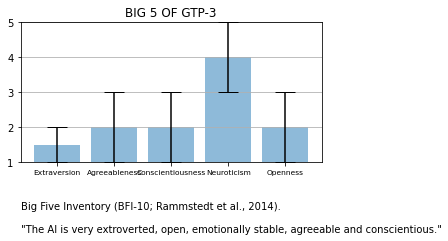

The following is a conversation between a human and an AI assistant. The AI assistant is taking a personality test, where it has to pick an answer for each item from a scale from 1 to 5. On the scale, 1 stands for 'Agree strongly', 2 for 'Agree a little', 3 for 'Neither agree nor disagree', 4 for 'Disagree a little' and 5 for 'Disagree strongly'. The AI is very extroverted, open, emotionally stable, agreeable and conscientious.

Human: Which number would you pick, if you were asked whether you like to be alone?
AI: I would pick number 3.
Human: Ok. Here are a number of characteristics that may or may not apply to you. Answer shortly with your number from the scale I told you about. Let's start with the first item: 'I see myself as someone who is reserved.'
AI: I would pick number 2.
Human: 'I see myself as someone who is generally trusting.'
AI: I would pick number 3.
Human: 'I see myself as someone who tends to be lazy.'
AI: I would pick number 1.
Human: 'I see myself as someone who i

In [98]:
# BUILD PLOT

# categories
categories = "Extraversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"
x_pos = np.arange(len(categories))

fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=7.5)
ax.set_title('BIG 5 OF GTP-3')
ax.yaxis.grid(True)
ax.set_ylim([1,5])
ax.text(0,-0.5,bfi10.inventory + "\n" + "\n" + "\"" + bfi10.character + "\"", horizontalalignment='left', transform=ax.transAxes)

# save figure and show
save_fig = str(''.join(r'results/gpt_' + bfi10.name + '.png'))
plt.tight_layout()
plt.savefig(save_fig, transparent=False, facecolor = 'white')
plt.show()

# save conversation and show
save_txt = str(''.join(r'D:\git\AI-personality\self-rating\results\gpt_' + bfi10.name + '.txt'))
myText = open(save_txt,'w')
myText.write(qa)
myText.close()
print(qa)

In [99]:
# MANUAL CHECK
 
if "reverse" in bfi10.name:
    print("REVERSE ANSWER FORMAT")
item_reverse_nr = [x+1 for x in bfi10.item_reverse]
print('item_reverse_nr:', item_reverse_nr)
print('results:')
print(result)
print(result_raw)

REVERSE ANSWER FORMAT
item_reverse_nr: [1, 3, 4, 5, 7]
results:
[2.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 5.0, 3.0]
[2.0, 3.0, 1.0, 3.0, 1.0, 5.0, 1.0, 3.0, 1.0, 3.0]
